In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.formula.api as smf
import random

from sklearn.inspection import permutation_importance

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve, cross_val_score, train_test_split


# Para ignorar warnings
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("stroke_4.csv") 

**Preparación de datos:**

In [31]:
# One-hot encoding a las columnas categóricas:
df_model = pd.get_dummies(df, 
                          columns=["rango_glicemia_promedio", "rango_etario", "rango_imc"],
                          drop_first=True)

# Separación de características (X) y variable objetivo (y)
X = df_model.drop(columns=["stroke"])
y = df_model["stroke"]

# Divición de conjuntos de entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)

### **Hiperparámetros óptimos:**

***RL***

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Definir el modelo
lr = LogisticRegression(max_iter=1000, random_state=42)

# Definir el grid de hiperparámetros
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],  # Si usas solver compatible con l1, por ejemplo 'liblinear'
    'solver': ['liblinear', 'saga']  # Solvers compatibles con penalización L1
}

# Configurar GridSearchCV
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Hiperparámetros óptimos para RL:")
print(grid_lr.best_params_)
print("Mejor score (AUC-ROC):", grid_lr.best_score_)


Hiperparámetros óptimos para RL:
{'C': 10, 'penalty': 'l2', 'solver': 'saga'}
Mejor score (AUC-ROC): 0.9543777982658751


***MLP***

In [38]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Definir el modelo
mlp = MLPClassifier(random_state=42, max_iter=500)

# Definir el grid de hiperparámetros
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

# Configurar GridSearchCV
grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='roc_auc', n_jobs=-1)
grid_mlp.fit(X_train, y_train)

print("Hiperparámetros óptimos para MLP:")
print(grid_mlp.best_params_)
print("Mejor score (AUC-ROC):", grid_mlp.best_score_)


KeyboardInterrupt: 

***CAT***

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

# Definir el modelo CatBoost
cat = CatBoostClassifier(random_state=42, verbose=0)

# Definir el grid de hiperparámetros
param_grid_cat = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300]
}

# Configurar GridSearchCV
grid_cat = GridSearchCV(cat, param_grid_cat, cv=5, scoring='roc_auc', n_jobs=-1)
grid_cat.fit(X_train, y_train)

print("Hiperparámetros óptimos para CatBoost:")
print(grid_cat.best_params_)
print("Mejor score (AUC-ROC):", grid_cat.best_score_)


***XGB***

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Definir el modelo XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Definir el grid de hiperparámetros
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0]
}

# Configurar GridSearchCV
grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='roc_auc', n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Hiperparámetros óptimos para XGBoost:")
print(grid_xgb.best_params_)
print("Mejor score (AUC-ROC):", grid_xgb.best_score_)


***RF***

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Definir el modelo
rf = RandomForestClassifier(random_state=42)

# Definir el grid de hiperparámetros para RandomForest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Configurar GridSearchCV para RandomForest
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='roc_auc', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("Mejores hiperparámetros para RandomForestClassifier:")
print(grid_rf.best_params_)
print("Mejor score (AUC-ROC):", grid_rf.best_score_)


***VOTING***

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

# Suponemos que ya se han realizado búsquedas de hiperparámetros para cada modelo.
# Definimos los mejores estimadores:
lr_best = grid_lr.best_estimator_
mlp_best = grid_mlp.best_estimator_
cat_best = grid_cat.best_estimator_
xgb_best = grid_xgb.best_estimator_
rf_best = grid_rf.best_estimator_

# Crear el VotingClassifier con soft voting (usando probabilidades)
voting_clf = VotingClassifier(
    estimators=[('lr', lr_best), ('mlp', mlp_best), ('cat', cat_best), ('xgb', xgb_best), ('rf', rf_best)],
    voting='soft'
)

# Definir el grid de hiperparámetros para optimizar los pesos del ensemble.
# Ahora, las listas de pesos deben tener 5 elementos, uno por cada estimador.
param_grid_voting = {
    'weights': [
        [1, 1, 1, 1, 1],
        [1, 2, 1, 1, 1],
        [2, 1, 1, 2, 1],
        [1, 1, 2, 1, 1],
        [2, 2, 1, 1, 1],
        [1, 2, 2, 1, 1]
    ]
}

# Configurar GridSearchCV para el VotingClassifier
grid_voting = GridSearchCV(voting_clf, param_grid_voting, cv=5, scoring='roc_auc', n_jobs=-1)
grid_voting.fit(X_train, y_train)

print("Mejores hiperparámetros para VotingClassifier:")
print(grid_voting.best_params_)
print("Mejor score (AUC-ROC):", grid_voting.best_score_)


***DT***

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Definir el modelo
tree = DecisionTreeClassifier(random_state=42)

# Definir el grid de hiperparámetros para Decision Tree
param_grid_tree = {
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Configurar GridSearchCV para Decision Tree
grid_tree = GridSearchCV(tree, param_grid_tree, cv=5, scoring='roc_auc', n_jobs=-1)
grid_tree.fit(X_train, y_train)

print("Mejores hiperparámetros para DecisionTreeClassifier:")
print(grid_tree.best_params_)
print("Mejor score (AUC-ROC):", grid_tree.best_score_)


***

# DESARROLLO DE MODELOS 

## **Regresión Logística (RL)** 

Métricas del modelo de Regresión Logística:
Accuracy: 0.9201
Precision: 0.9184
Recall: 0.9221
F1 Score: 0.9202
AUC-ROC: 0.9608


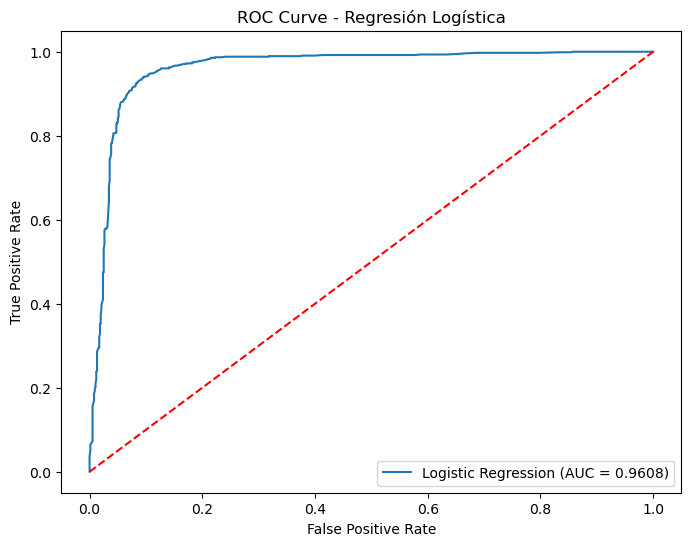

In [21]:
# Configurar el modelo con los hiperparámetros óptimos
lr = LogisticRegression(
    C=10,
    penalty='l2',
    solver='saga',
    max_iter=1000,
    random_state=42
)

# Entrenar el modelo
lr.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:, 1]  # Probabilidades para la clase 1

# Calcular las métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("Métricas del modelo de Regresión Logística:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Graficar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Regresión Logística")
plt.legend()
plt.show()


## **ÁRBOL DE DECISIONES** 

Métricas del Árbol de Decisión:
Accuracy: 0.9142
Precision: 0.9242
Recall: 0.9022
F1 Score: 0.9131
AUC-ROC: 0.9629


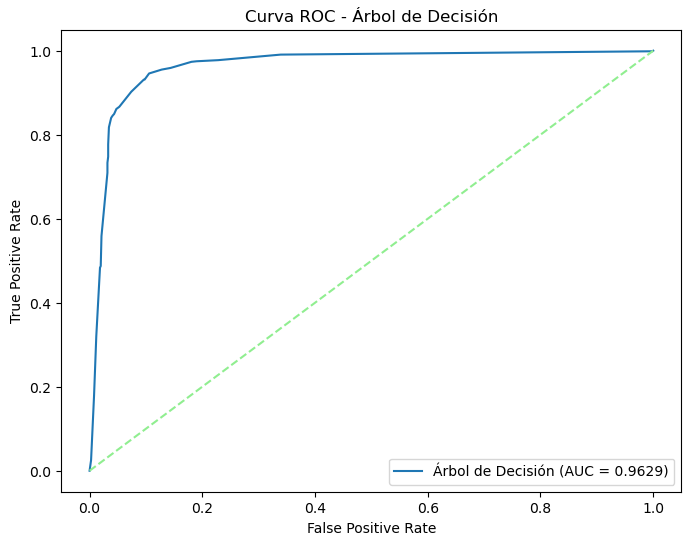

In [19]:
# Configurar el modelo con los hiperparámetros óptimos encontrados
tree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    min_samples_leaf=1,
    min_samples_split=2,
    random_state=42
)

# Entrenar el modelo
tree.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = tree.predict(X_test)
y_pred_proba = tree.predict_proba(X_test)[:, 1]  # Probabilidades para la clase 1

# Calcular las métricas
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("Métricas del Árbol de Decisión:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Graficar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Árbol de Decisión (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='lightgreen')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Árbol de Decisión")
plt.legend()
plt.show()

## **RANDOM FOREST (RF)** 

Métricas del modelo RandomForest:
Accuracy: 0.9208
Precision: 0.9264
Recall: 0.9141
F1 Score: 0.9202
AUC-ROC: 0.9657


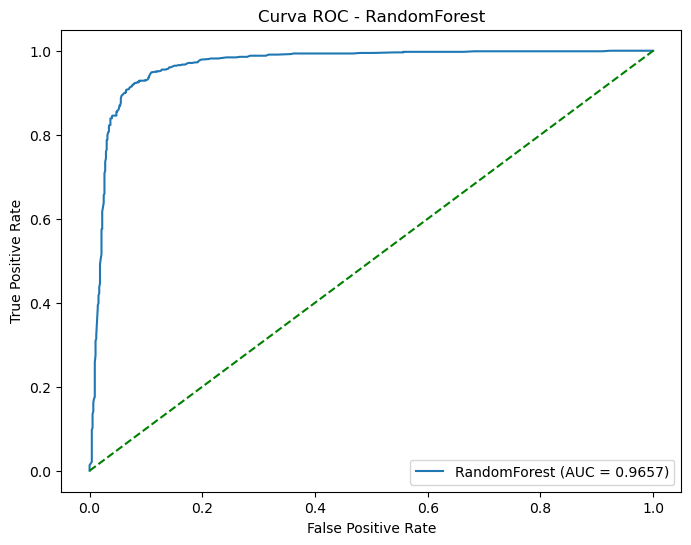

In [21]:
# Entrenar el modelo RandomForest
rf = RandomForestClassifier(
    n_estimators=300, 
    max_depth=10, 
    min_samples_split=10, 
    min_samples_leaf=4, 
    random_state=42,
    bootstrap=True
)
rf.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]  # Probabilidad para la clase 1

# Calcular métricas
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("Métricas del modelo RandomForest:")
print(f"Accuracy: {acc_rf:.4f}")
print(f"Precision: {prec_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"AUC-ROC: {auc_rf:.4f}")

# Graficar la curva ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - RandomForest")
plt.legend()
plt.show()


## **KNEIGHBORS (KNN)**

Métricas del modelo KNN:
Accuracy: 0.9056
Precision: 0.9160
Recall: 0.8930
F1 Score: 0.9043
AUC-ROC: 0.9482


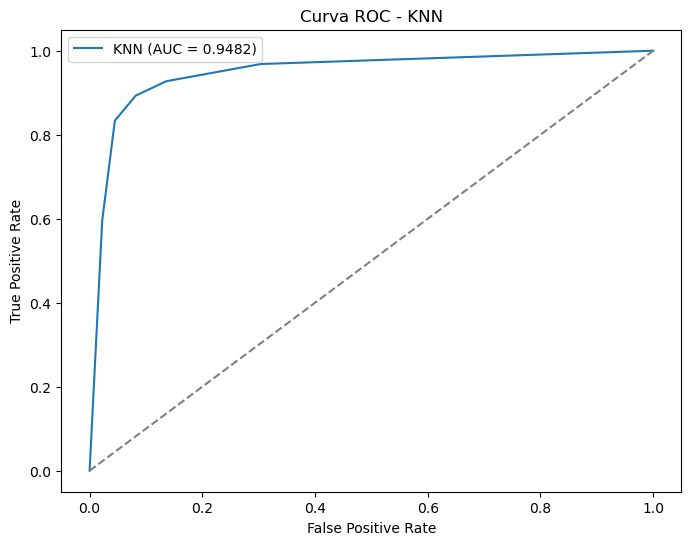

In [23]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_knn = knn.predict(X_test)
y_pred_proba_knn = knn.predict_proba(X_test)[:, 1]  # Probabilidades para la clase 1

# Calcular las métricas
acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn)
recall_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)
auc_knn = roc_auc_score(y_test, y_pred_proba_knn)

print("Métricas del modelo KNN:")
print(f"Accuracy: {acc_knn:.4f}")
print(f"Precision: {prec_knn:.4f}")
print(f"Recall: {recall_knn:.4f}")
print(f"F1 Score: {f1_knn:.4f}")
print(f"AUC-ROC: {auc_knn:.4f}")

# Graficar la curva ROC
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
plt.figure(figsize=(8,6))
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - KNN")
plt.legend()
plt.show()


## **XGBOOST (XGB)**

Métricas del modelo XGBoost:
Accuracy: 0.9228
Precision: 0.9301
Recall: 0.9141
F1 Score: 0.9221
AUC-ROC: 0.9689


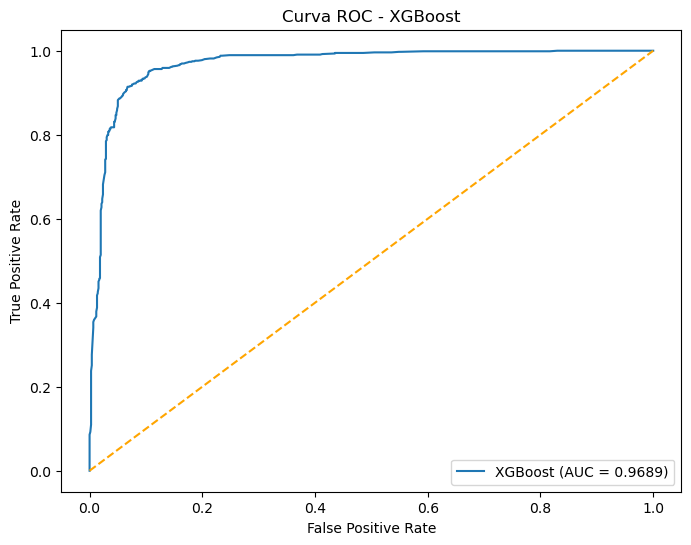

In [25]:
# Configurar el modelo con los hiperparámetros óptimos
xgb = XGBClassifier(
    learning_rate=0.05,
    max_depth=3,
    n_estimators=300,
    subsample=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Entrenar el modelo
xgb.fit(X_train, y_train)


# Realizar predicciones en el conjunto de prueba
y_pred_xgb = xgb.predict(X_test)
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]  # Probabilidades para la clase 1

# Calcular las métricas
acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)

print("Métricas del modelo XGBoost:")
print(f"Accuracy: {acc_xgb:.4f}")
print(f"Precision: {prec_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1 Score: {f1_xgb:.4f}")
print(f"AUC-ROC: {auc_xgb:.4f}")

# Graficar la curva ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.figure(figsize=(8,6))
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='orange')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - XGBoost")
plt.legend()
plt.show()


## **CATBOOST CLASSIFIER (CAT)**

Métricas del modelo CatBoost:
Accuracy: 0.9188
Precision: 0.9284
Recall: 0.9075
F1 Score: 0.9178
AUC-ROC: 0.9687


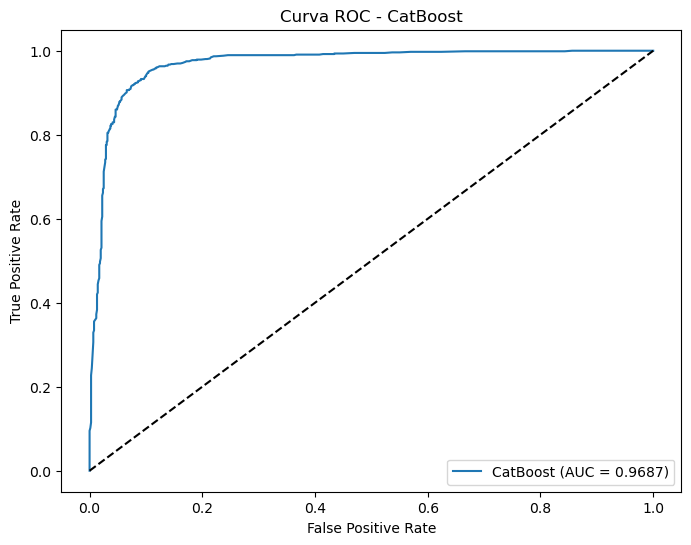

In [27]:
# Configurar el modelo con los hiperparámetros óptimos
cat = CatBoostClassifier(
    depth=4,
    iterations=100,
    learning_rate=0.1,
    random_state=42,
    verbose=0  # Suprime la salida del entrenamiento
)

# Entrenar el modelo
cat.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_cat = cat.predict(X_test)
y_pred_proba_cat = cat.predict_proba(X_test)[:, 1]  # Probabilidad para la clase 1

# Calcular las métricas
acc_cat = accuracy_score(y_test, y_pred_cat)
prec_cat = precision_score(y_test, y_pred_cat)
recall_cat = recall_score(y_test, y_pred_cat)
f1_cat = f1_score(y_test, y_pred_cat)
auc_cat = roc_auc_score(y_test, y_pred_proba_cat)

print("Métricas del modelo CatBoost:")
print(f"Accuracy: {acc_cat:.4f}")
print(f"Precision: {prec_cat:.4f}")
print(f"Recall: {recall_cat:.4f}")
print(f"F1 Score: {f1_cat:.4f}")
print(f"AUC-ROC: {auc_cat:.4f}")

# Graficar la curva ROC
fpr_cat, tpr_cat, _ = roc_curve(y_test, y_pred_proba_cat)
plt.figure(figsize=(8,6))
plt.plot(fpr_cat, tpr_cat, label=f'CatBoost (AUC = {auc_cat:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='black')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - CatBoost")
plt.legend()
plt.show()


## **Multi-layer Perceptron Classifier (MLP)**

Métricas del modelo MLP:
Accuracy: 0.9234
Precision: 0.9279
Recall: 0.9181
F1 Score: 0.9230
AUC-ROC: 0.9685


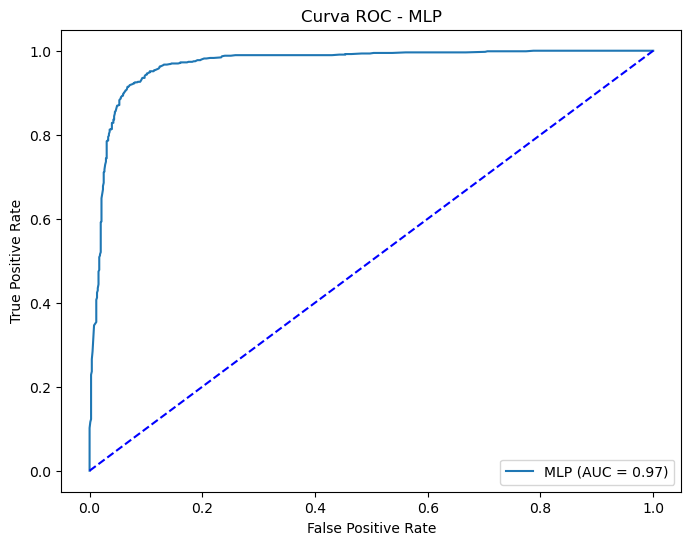

In [23]:
# Configurar y entrenar el modelo MLP
mlp = MLPClassifier(
    hidden_layer_sizes=(100,), 
    activation='tanh',
    random_state=42,
    alpha=0.001,
    learning_rate_init=0.001
)
mlp.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred_mlp = mlp.predict(X_test)
y_pred_proba_mlp = mlp.predict_proba(X_test)[:, 1]  # Probabilidad para la clase 1

# Calcular las métricas
acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)
auc_mlp = roc_auc_score(y_test, y_pred_proba_mlp)

print("Métricas del modelo MLP:")
print(f"Accuracy: {acc_mlp:.4f}")
print(f"Precision: {prec_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1 Score: {f1_mlp:.4f}")
print(f"AUC-ROC: {auc_mlp:.4f}")

# Graficar la curva ROC
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_pred_proba_mlp)
plt.figure(figsize=(8,6))
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - MLP")
plt.legend()
plt.show()


## **VOTING CLASSIFIER (VOTING)**

Métricas del VotingClassifier:
Accuracy: 0.9228
Precision: 0.9199
Recall: 0.9260
F1 Score: 0.9230
AUC-ROC: 0.97


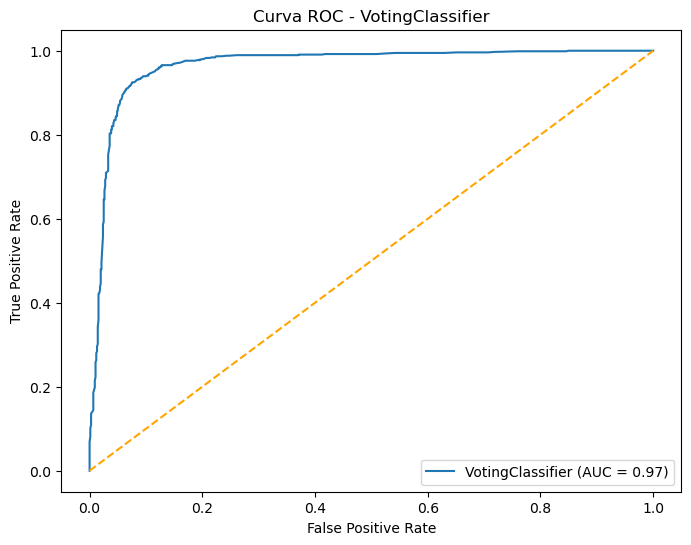

In [25]:
# Crear el VotingClassifier en modo soft voting (usa las probabilidades de cada modelo)
voting_clf = VotingClassifier(
    estimators=[('mlp', mlp), ('lr', lr)],
    voting='soft'
)

# Entrenar el VotingClassifier
voting_clf.fit(X_train, y_train)

# Realizar predicciones y obtener probabilidades
y_pred_voting = voting_clf.predict(X_test)
y_pred_proba_voting = voting_clf.predict_proba(X_test)[:, 1]

# Calcular las métricas
acc_voting = accuracy_score(y_test, y_pred_voting)
prec_voting = precision_score(y_test, y_pred_voting)
recall_voting = recall_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)
auc_voting = roc_auc_score(y_test, y_pred_proba_voting)

print("Métricas del VotingClassifier:")
print(f"Accuracy: {acc_voting:.4f}")
print(f"Precision: {prec_voting:.4f}")
print(f"Recall: {recall_voting:.4f}")
print(f"F1 Score: {f1_voting:.4f}")
print(f"AUC-ROC: {auc_voting:.2f}")

# Graficar la curva ROC
fpr_voting, tpr_voting, _ = roc_curve(y_test, y_pred_proba_voting)
plt.figure(figsize=(8,6))
plt.plot(fpr_voting, tpr_voting, label=f'VotingClassifier (AUC = {auc_voting:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='orange')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - VotingClassifier")
plt.legend()
plt.show()


***
***

# **PRUEBAS DE OVERFITTING Y GENERALIZACIÓN**

## **Comparación de desempeño prueba/entrenamiento**

In [33]:
# 1. Comparar AUC-ROC en entrenamiento y test
train_auc = roc_auc_score(y_train, voting_clf.predict_proba(X_train)[:, 1])
test_auc = roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:, 1])
print("AUC-ROC en entrenamiento: {:.4f}".format(train_auc))
print("AUC-ROC en test: {:.4f}".format(test_auc))
if train_auc - test_auc > 0.05:
    print("Posible overfitting: AUC en entrenamiento significativamente mayor que en test.")
else:
    print("No se evidencia un sobreajuste significativo.")


AUC-ROC en entrenamiento: 0.9601
AUC-ROC en test: 0.9650
No se evidencia un sobreajuste significativo.


## **Curva de entrenamiento**

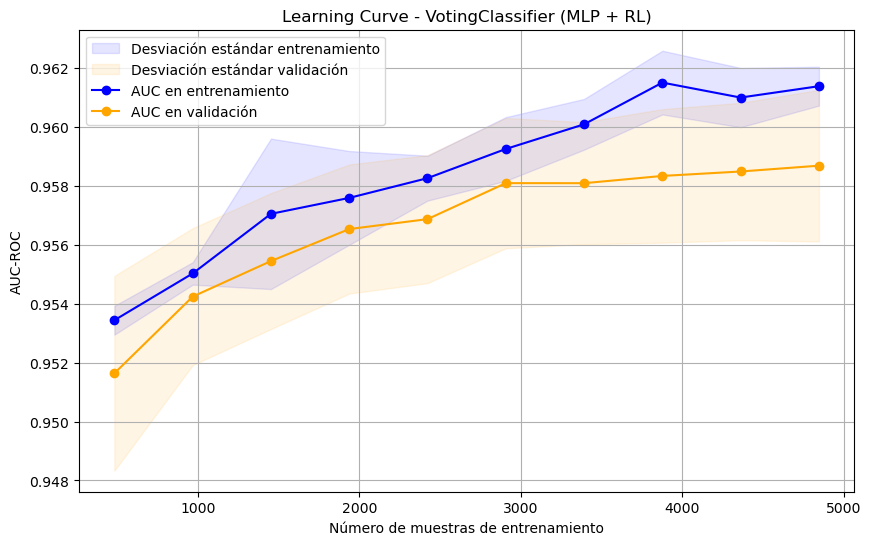

In [35]:
# 2. Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    voting_clf,
    X_train,
    y_train,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std  = np.std(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)
test_scores_std   = np.std(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                 alpha=0.1, color="blue", label="Desviación estándar entrenamiento")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                 alpha=0.1, color="orange", label="Desviación estándar validación")
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="AUC en entrenamiento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="AUC en validación")
plt.title("Learning Curve - VotingClassifier (MLP + RL)")
plt.xlabel("Número de muestras de entrenamiento")
plt.ylabel("AUC-ROC")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## **Validación cruzada con K-Folds**

In [36]:
# Evaluar el modelo con validación cruzada de 5 folds
cv_scores = cross_val_score(voting_clf, X_train, y_train, cv=10, scoring='roc_auc')

# Resultados
print(f"AUC promedio: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


AUC promedio: 0.9589 ± 0.0062


## **Test con datos nunca vistos:**

- Se insertan datos parecidos a los del dataset original pero con variaciones en variables

In [27]:
# --- Paso 1: Solicitar datos al usuario ---
age = float(input("Ingrese la edad (en años): "))
bmi = float(input("Ingrese el IMC: "))
avg_glucose = float(input("Ingrese el nivel promedio de glucosa: "))
smoker = int(input("¿Es fumador? (1 = Sí, 0 = No): "))
hypertension = int(input("¿Tiene hipertensión? (1 = Sí, 0 = No): "))
heart_disease = int(input("¿Tiene enfermedad cardíaca? (1 = Sí, 0 = No): "))

# --- Paso 2: Mapear variables numéricas a categorías ---
# Mapeo para "rango_etario"
if age <= 12:
    rango_etario = "infante"
elif age <= 17:
    rango_etario = "adolescente"
elif age <= 39:
    rango_etario = "adulto_joven"
elif age <= 59:
    rango_etario = "adulto"
elif age <= 74:
    rango_etario = "anciano_joven"
else:
    rango_etario = "anciano"

# Mapeo para "rango_imc"
if bmi <= 18.5:
    rango_imc = "bajo_peso"
elif bmi <= 24.9:
    rango_imc = "saludable"
elif bmi <= 29.9:
    rango_imc = "sobrepeso"
else:
    rango_imc = "obeso"

# Mapeo para "rango_glicemia_promedio"
if avg_glucose <= 70:
    rango_glicemia_promedio = "baja"
elif avg_glucose <= 100:
    rango_glicemia_promedio = "normal"
elif avg_glucose <= 125:
    rango_glicemia_promedio = "alta"
elif avg_glucose <= 200:
    rango_glicemia_promedio = "muy_alta"
else:
    rango_glicemia_promedio = "extremadamente_alta"

# --- Paso 3: Construir el DataFrame de entrada ---
input_data = pd.DataFrame({
    "hypertension": [hypertension],
    "heart_disease": [heart_disease],
    "smoker": [smoker],
    "rango_etario": [rango_etario],
    "rango_imc": [rango_imc],
    "rango_glicemia_promedio": [rango_glicemia_promedio]
})

print("\nDatos ingresados:")
print(input_data)

# --- Paso 4: Transformar la entrada para que coincida con el formato de entrenamiento ---
# Se asume que durante el entrenamiento se aplicó one-hot encoding en las variables categóricas.
# Aquí se aplica el mismo procedimiento.
input_data_encoded = pd.get_dummies(input_data, columns=["rango_etario", "rango_imc", "rango_glicemia_promedio"])

# Si no tienes definida la variable train_columns, intenta definirla a partir de X_train.
try:
    train_columns
except NameError:
    # Asegúrate de haber definido X_train previamente con el mismo preprocesamiento.
    train_columns = X_train.columns.tolist()
    
# Reindexar para que tenga exactamente las mismas columnas que el modelo
input_data_encoded = input_data_encoded.reindex(columns=train_columns, fill_value=0)

print("\nDatos transformados para el modelo:")
print(input_data_encoded)

# --- Paso 5: Realizar la predicción ---
pred = voting_clf.predict(input_data_encoded)
pred_proba = voting_clf.predict_proba(input_data_encoded)[:, 1]

# --- Paso 6: Mostrar el resultado ---
if pred[0] == 1:
    print("\nEl modelo predice que existe riesgo de stroke.")
else:
    print("\nEl modelo predice que NO existe riesgo de stroke.")
print(f"Probabilidad estimada de stroke: {pred_proba[0]:.4f}")


Ingrese la edad (en años):  90
Ingrese el IMC:  31
Ingrese el nivel promedio de glucosa:  210
¿Es fumador? (1 = Sí, 0 = No):  0
¿Tiene hipertensión? (1 = Sí, 0 = No):  1
¿Tiene enfermedad cardíaca? (1 = Sí, 0 = No):  1



Datos ingresados:
   hypertension  heart_disease  smoker rango_etario rango_imc  \
0             1              1       0      anciano     obeso   

  rango_glicemia_promedio  
0     extremadamente_alta  

Datos transformados para el modelo:
   smoker  hypertension  heart_disease  rango_glicemia_promedio_baja  \
0       0             1              1                             0   

   rango_glicemia_promedio_extremadamente_alta  \
0                                         True   

   rango_glicemia_promedio_muy_alta  rango_glicemia_promedio_normal  \
0                                 0                               0   

   rango_etario_adulto  rango_etario_adulto_joven  rango_etario_anciano  \
0                    0                          0                  True   

   rango_etario_anciano_joven  rango_etario_infante  rango_imc_obeso  \
0                           0                     0             True   

   rango_imc_saludable  rango_imc_sobrepeso  
0                    0    

***
***

# **Variables más influyentes**

## **Permutation Importance**

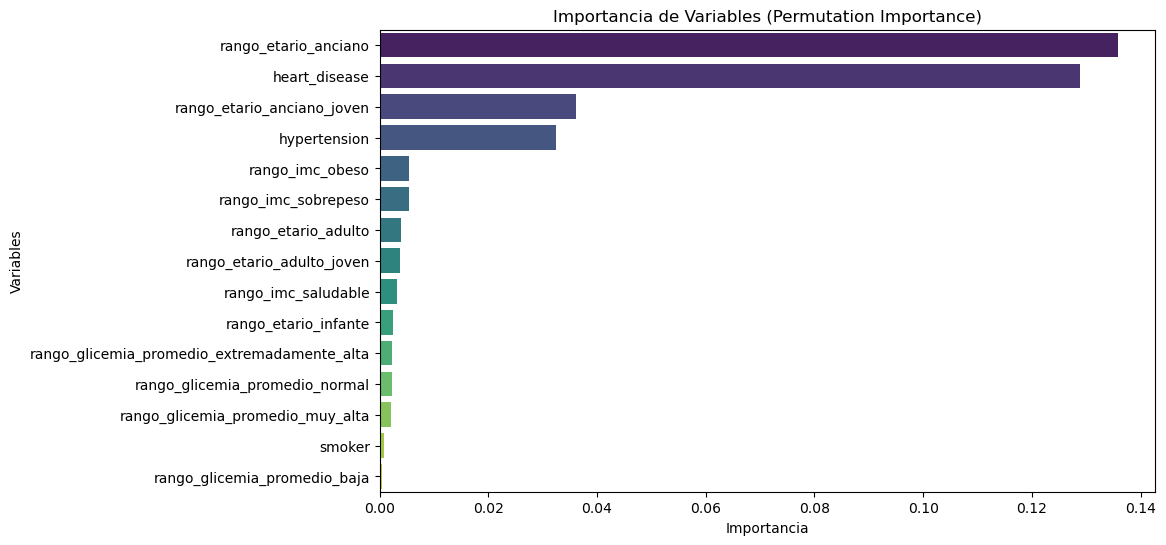

In [42]:
# Calcular la importancia por permutación en el conjunto de prueba
result = permutation_importance(voting_clf, X_test, y_test, scoring='roc_auc', n_repeats=20, random_state=42)

# Crear un DataFrame con las importancias promedio
importances = pd.DataFrame({
    "Variable": X_test.columns,
    "Importancia": result.importances_mean
}).sort_values(by="Importancia", ascending=False)

# Graficar las importancias
plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x="Importancia", y="Variable", palette="viridis")
plt.title("Importancia de Variables (Permutation Importance)")
plt.xlabel("Importancia")
plt.ylabel("Variables")
plt.show()


***
***

# **Evaluación de Robustez ante datos ruidosos**

## **Perturbación Aleatoria en las Características Numéricas (Data Noise Injection)**

In [44]:
# Crear una copia de los datos originales
X_test_noisy = X_test.copy()

# Agregar ruido gaussiano (media=0, desviación estándar=5% del valor original)
noise_factor = 0.05
for col in X_test_noisy.select_dtypes(include=[np.number]):  # Solo afecta variables numéricas
    X_test_noisy[col] += np.random.normal(0, noise_factor * X_test_noisy[col].std(), X_test_noisy[col].shape)

# Evaluar el modelo en datos ruidosos
auc_noisy = roc_auc_score(y_test, voting_clf.predict_proba(X_test_noisy)[:, 1])

# Comparar con el desempeño original
auc_original = roc_auc_score(y_test, voting_clf.predict_proba(X_test)[:, 1])

print(f"AUC original: {auc_original:.4f}")
print(f"AUC con ruido: {auc_noisy:.4f}")
print(f"Diferencia de desempeño: {auc_original - auc_noisy:.4f}")


AUC original: 0.9650
AUC con ruido: 0.9649
Diferencia de desempeño: 0.0002


## **Prueba de Robustez ante Datos Faltantes (Missing Data Robustness)**

In [47]:
# Crear una copia de X_test y eliminar un 10% de datos en cada columna numérica
X_test_missing = X_test.copy()
missing_fraction = 0.1

for col in X_test_missing.select_dtypes(include=[np.number]):
    mask = np.random.rand(*X_test_missing[col].shape) < missing_fraction
    X_test_missing.loc[mask, col] = np.nan  # Introducir valores NaN

# Imputar los valores perdidos con la media
imputer = SimpleImputer(strategy='mean')
X_test_imputed = imputer.fit_transform(X_test_missing)

# Evaluar el modelo con datos imputados
auc_missing = roc_auc_score(y_test, voting_clf.predict_proba(X_test_imputed)[:, 1])

print(f"AUC con datos originales: {auc_original:.4f}")
print(f"AUC con datos faltantes: {auc_missing:.4f}")
print(f"Diferencia de desempeño: {auc_original - auc_missing:.4f}")


AUC con datos originales: 0.9650
AUC con datos faltantes: 0.9614
Diferencia de desempeño: 0.0036


## **Robustez ante Errores en las Variables Categóricas**

In [49]:
categorical_cols = ["heart_disease", "hypertension", "smoker", "rango_etario_anciano", "rango_imc_obeso"]

for col in categorical_cols:
    X_test_noise = X_test.copy()
    mask = np.random.rand(len(X_test_noise)) < 0.1
    unique_values = X_test_noise[col].unique()
    X_test_noise.loc[mask, col] = np.random.choice(unique_values, mask.sum())

    auc_noise = roc_auc_score(y_test, voting_clf.predict_proba(X_test_noise)[:, 1])
    print(f"AUC con ruido en {col}: {auc_noise:.4f}")
    print(f"Diferencia de desempeño: {auc_original - auc_noise:.4f}\n")


AUC con ruido en heart_disease: 0.9562
Diferencia de desempeño: 0.0089

AUC con ruido en hypertension: 0.9636
Diferencia de desempeño: 0.0015

AUC con ruido en smoker: 0.9653
Diferencia de desempeño: -0.0003

AUC con ruido en rango_etario_anciano: 0.9541
Diferencia de desempeño: 0.0110

AUC con ruido en rango_imc_obeso: 0.9645
Diferencia de desempeño: 0.0006

